# Define configs


In [ ]:
import os
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm
import glob
import random
import torchvision.ops as ops
import torchvision.transforms.functional as F
from transformers import DetrImageProcessor,DetrForObjectDetection,Trainer,TrainingArguments,TrainerCallback
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchmetrics.detection import MeanAveragePrecision
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

IMG_PATH = Path("/kaggle/input/dac204/images/images")
MODEL_CHECKPOINT ="facebook/detr-resnet-50"
IMAGE_EXTENSION = ".jpg"

CLASSES_ID_TO_LABELS = {
    0: "N/A",
    1: "biker", 2: "car", 3: "pedestrian", 4: "trafficlight",
    5: "trafficlight-green", 6: "trafficlight-greenleft",
    7: "trafficlight-red", 8: "trafficlight-redleft",
    9: "trafficlight-yellow", 10: "trafficlight-yellowleft",
    11: "truck", 12: "arret"
}
LABEL_TO_ID = {v: k for k, v in CLASSES_ID_TO_LABELS.items()}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


if not IMG_PATH.exists():
    raise FileNotFoundError(f"Image directory not found: {IMG_PATH}")

print("Imports and Setup complete.")
print(f"Image Path: {IMG_PATH}")
print(f"Number of classes: {len(CLASSES_ID_TO_LABELS)}")

Using device: cuda
Step 1: Imports and Setup complete.
Image Path: /kaggle/input/dac204/images/images
Number of classes: 13


# Load Model

In [8]:
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(CLASSES_ID_TO_LABELS), 
    id2label=CLASSES_ID_TO_LABELS,       
    label2id=LABEL_TO_ID,              
    ignore_mismatched_sizes=True      
).to(DEVICE)
processor = DetrImageProcessor.from_pretrained(MODEL_CHECKPOINT)
print("Model and Processor loaded.")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Model and Processor loaded.


In [9]:
model.load_state_dict(torch.load("/kaggle/input/notebooke6aff1d5b3/model_weights_38e.pth"))
model.eval()

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [10]:
for idx, label in model.config.id2label.items():
    print(f"{idx:2d} → {label}")

 0 → N/A
 1 → biker
 2 → car
 3 → pedestrian
 4 → trafficlight
 5 → trafficlight-green
 6 → trafficlight-greenleft
 7 → trafficlight-red
 8 → trafficlight-redleft
 9 → trafficlight-yellow
10 → trafficlight-yellowleft
11 → truck
12 → arret


# Data processing and loading

In [11]:
def load_data_paths(img_dir, ann_path):
    print(f"Scanning for images in {img_dir} and annotations {ann_path}")
    
    img_dir = Path(img_dir)
    coco = COCO(ann_path)

    img_ids = coco.getImgIds()
    imgs = coco.loadImgs(img_ids)

    img_paths = []
    missing_images = 0

    for img in tqdm(imgs):
        file_name = img['file_name']
        full_path = img_dir / file_name
        if full_path.exists():
            img_paths.append(full_path)
        else:
            missing_images += 1

    print(f"Found {len(img_paths)} correctly matched image/annotation pairs.")
    if missing_images > 0:
        print(f"Warning: {missing_images} image files listed in the annotation are missing in the image directory.")

    return img_paths, coco  

In [ ]:

SEED = 42
img_paths,coco = load_data_paths(IMG_PATH,'/kaggle/input/dac204/output_coco.json')


Scanning for images in /kaggle/input/dac204/images/images and annotations /kaggle/input/dac204/output_coco.json
loading annotations into memory...
Done (t=1.58s)
creating index...
index created!


  0%|          | 0/31676 [00:00<?, ?it/s]

Found 31676 correctly matched image/annotation pairs.


In [ ]:
# Shuffling with a fixed seed
SEED=40
random.seed(SEED)
random.shuffle(img_paths)

In [14]:
class COCODatasetForDETR(Dataset):
    def __init__(self, img_paths, coco):
        self.img_paths  = img_paths
        self.coco       = coco
        self.file_to_id = {img['file_name']: img['id'] 
                           for img in coco.dataset['images']}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.img_paths[idx]).convert("RGB")
        except OSError:
            idx=0
        img_path  = self.img_paths[idx]
        image     = Image.open(img_path).convert("RGB")
        image_id  = self.file_to_id[img_path.name]
        
        # pull raw COCO ann dicts
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))
        
        for ann in anns:
            ann.setdefault("area", ann["bbox"][2] * ann["bbox"][3])
            ann.setdefault("iscrowd", 0)

        return {
            "image":       image,
            "image_id":    image_id,
            "annotations": {
                "annotations": anns,
                "image_id":    image_id
            }
        }

In [15]:
test_paths= img_paths[int(len(img_paths)*0.75):]

In [16]:
test_dataset=COCODatasetForDETR(test_paths,coco)

In [17]:
DEVICE

device(type='cuda')

In [18]:
model.to(DEVICE)
print()

# Inference of the models 

In [20]:
FONT_SIZE=20
# FONT = ImageFont.truetype("/kaggle/input/fontfile/DejaVuSans.ttf", FONT_SIZE)
FONT = ImageFont.load_default()

DEVICE = 'cpu'
def draw_side_by_side(index):
    example = test_dataset[index]
    orig_image = example["image"]
    anns = example["annotations"]

    gt_boxes = torch.tensor(
        [ann['bbox'] for ann in anns['annotations']],
        dtype=torch.float32,
        device=DEVICE
    )
    # Convert (x, y, w, h) to (x0, y0, x1, y1)
    if len(gt_boxes) > 0:
        gt_boxes[:, 2] = gt_boxes[:, 0] + gt_boxes[:, 2]
        gt_boxes[:, 3] = gt_boxes[:, 1] + gt_boxes[:, 3]
    gt_labels = [model.config.id2label[ann['category_id']] for ann in anns['annotations']]

    inputs = processor(images=[orig_image], annotations=[anns], return_tensors="pt").to(DEVICE)
    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process predictions
    target_sizes = torch.tensor([orig_image.size[::-1]], device=DEVICE)
    results = processor.post_process_object_detection(
        outputs,
        threshold=0.5,
        target_sizes=target_sizes
    )[0]
    pred_boxes = results['boxes']
    pred_scores = results['scores']
    pred_labels = [model.config.id2label[l.item()] for l in results['labels']]

    img_gt = orig_image.copy()
    img_pred = orig_image.copy()

    # Draw ground-truth
    draw_gt = ImageDraw.Draw(img_gt)
    for box, label in zip(gt_boxes, gt_labels):
        x0, y0, x1, y1 = box.tolist()
        draw_gt.rectangle([x0, y0, x1, y1], width=3,outline = 'red')
        draw_gt.text((x0, y0), label, font=FONT)

    # Draw predictions
    draw_pred = ImageDraw.Draw(img_pred)
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        x0, y0, x1, y1 = box.tolist()
        draw_pred.rectangle([x0, y0, x1, y1], width=3,outline = 'red')
        draw_pred.text((x0, y0), f"{label} {score:.2f}", font=FONT)

    fig, axes = plt.subplots(1, 2, figsize=(24, 24))
    axes[0].imshow(img_gt)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    axes[1].imshow(img_pred)
    axes[1].set_title('Predictions')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [23]:
len(test_dataset)

7919

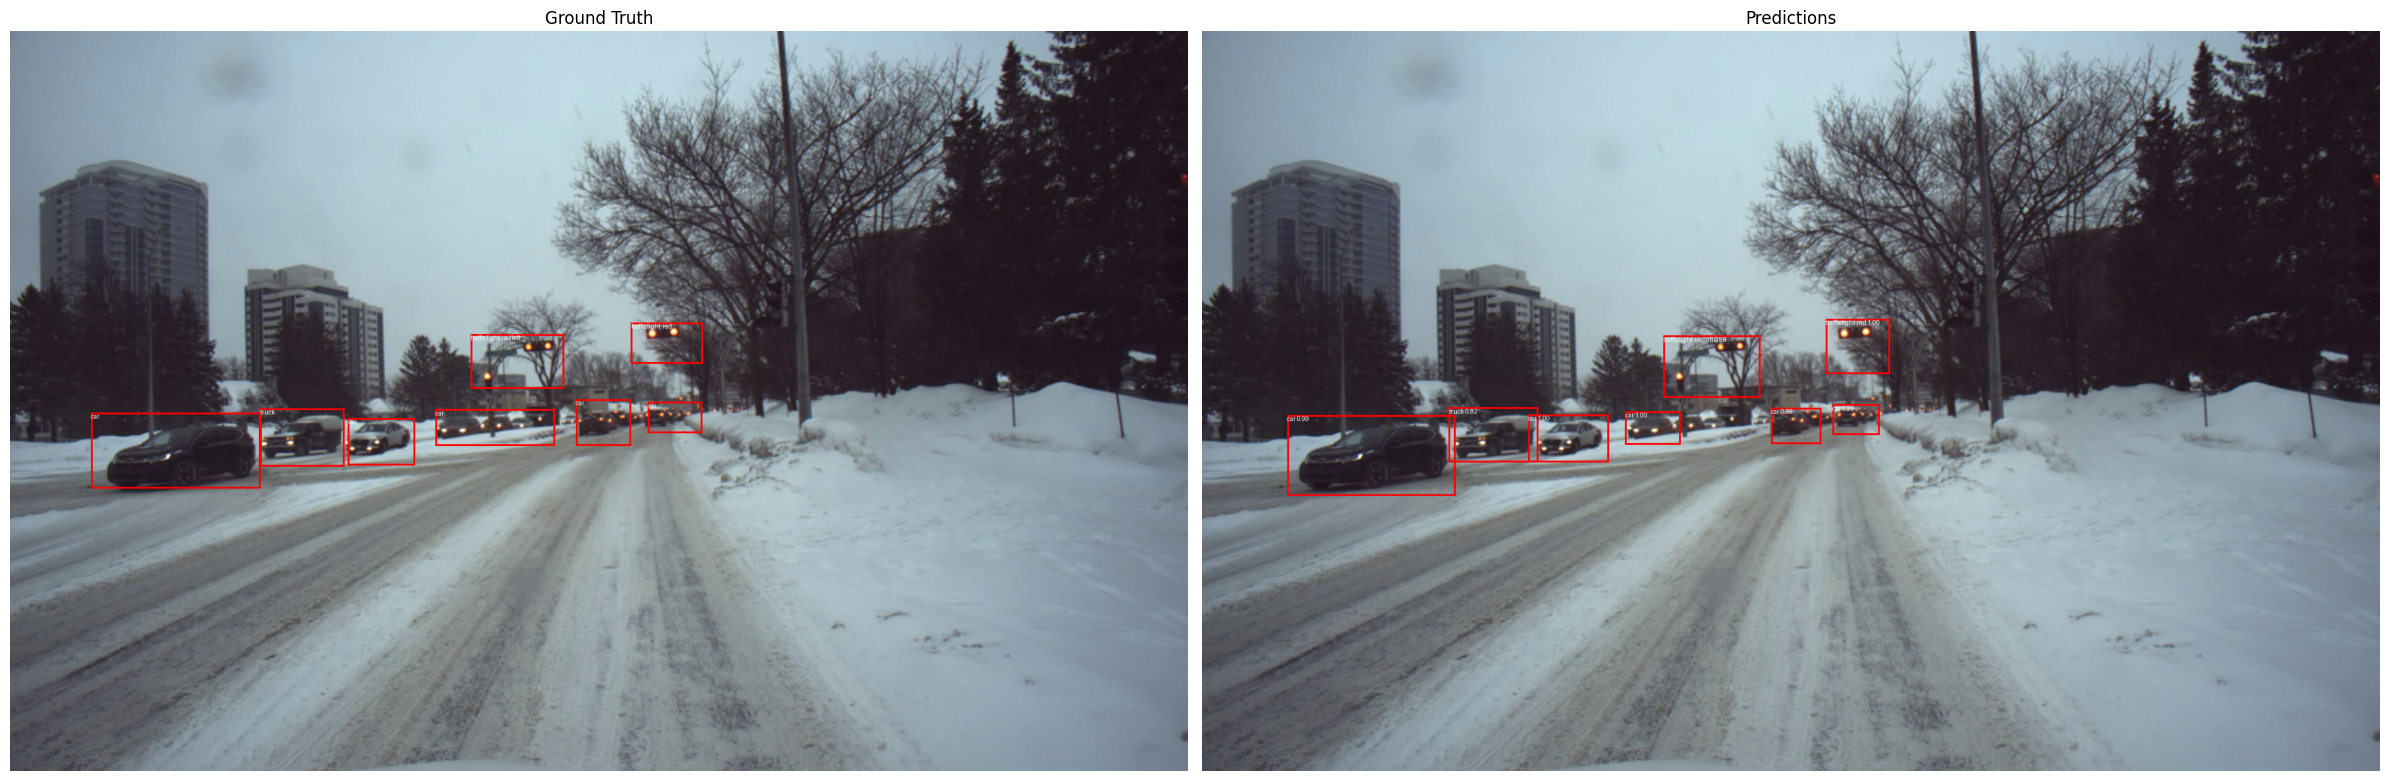

In [22]:
draw_side_by_side(596)

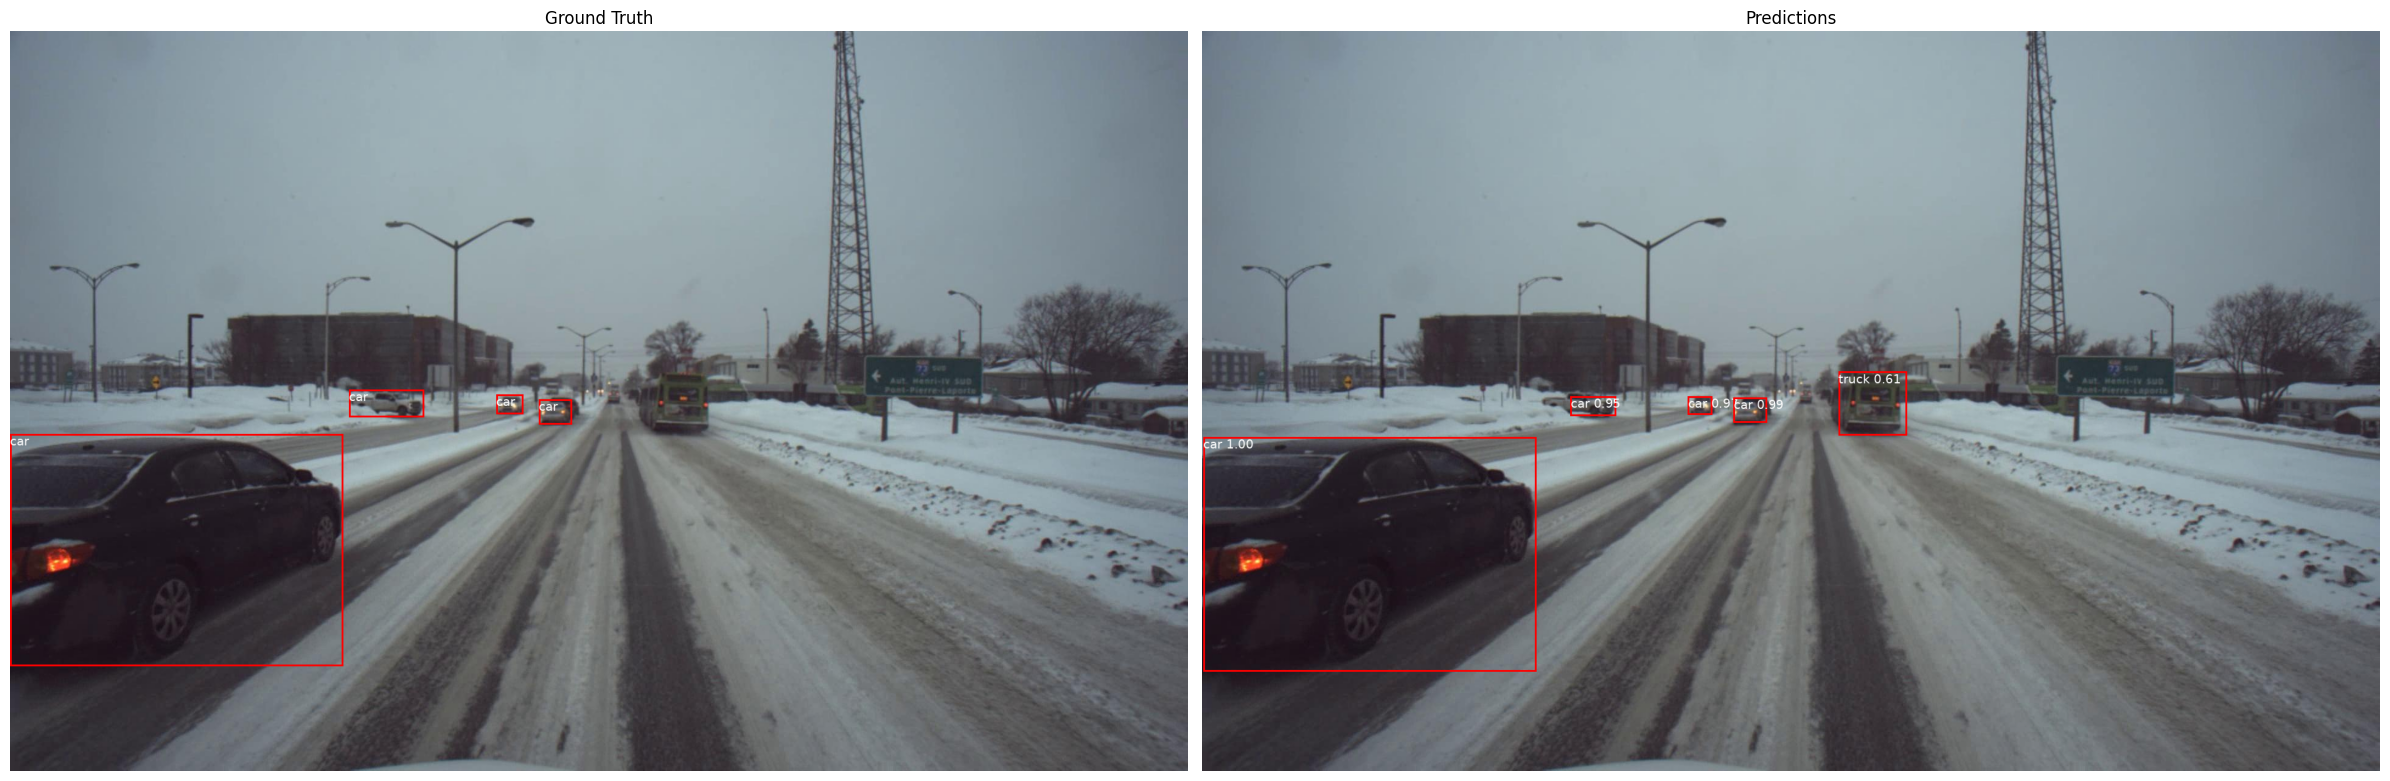

In [69]:
draw_side_by_side(123)

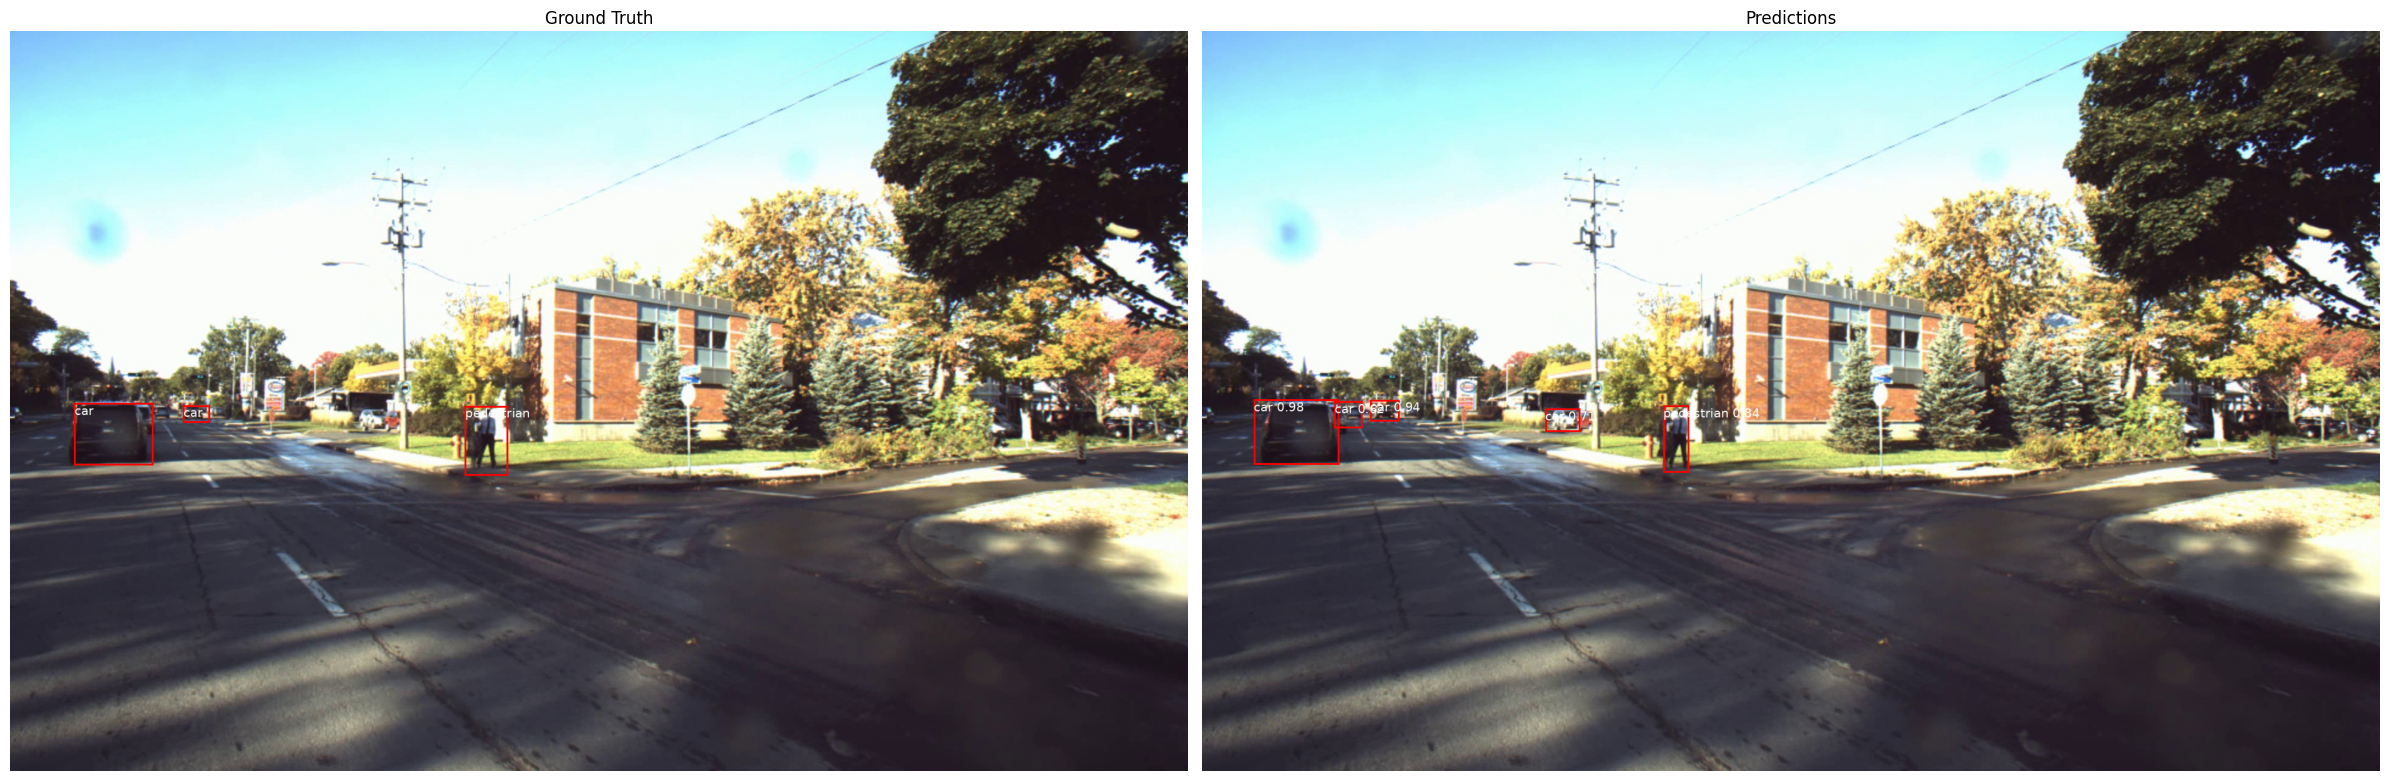

In [70]:
draw_side_by_side(2999)

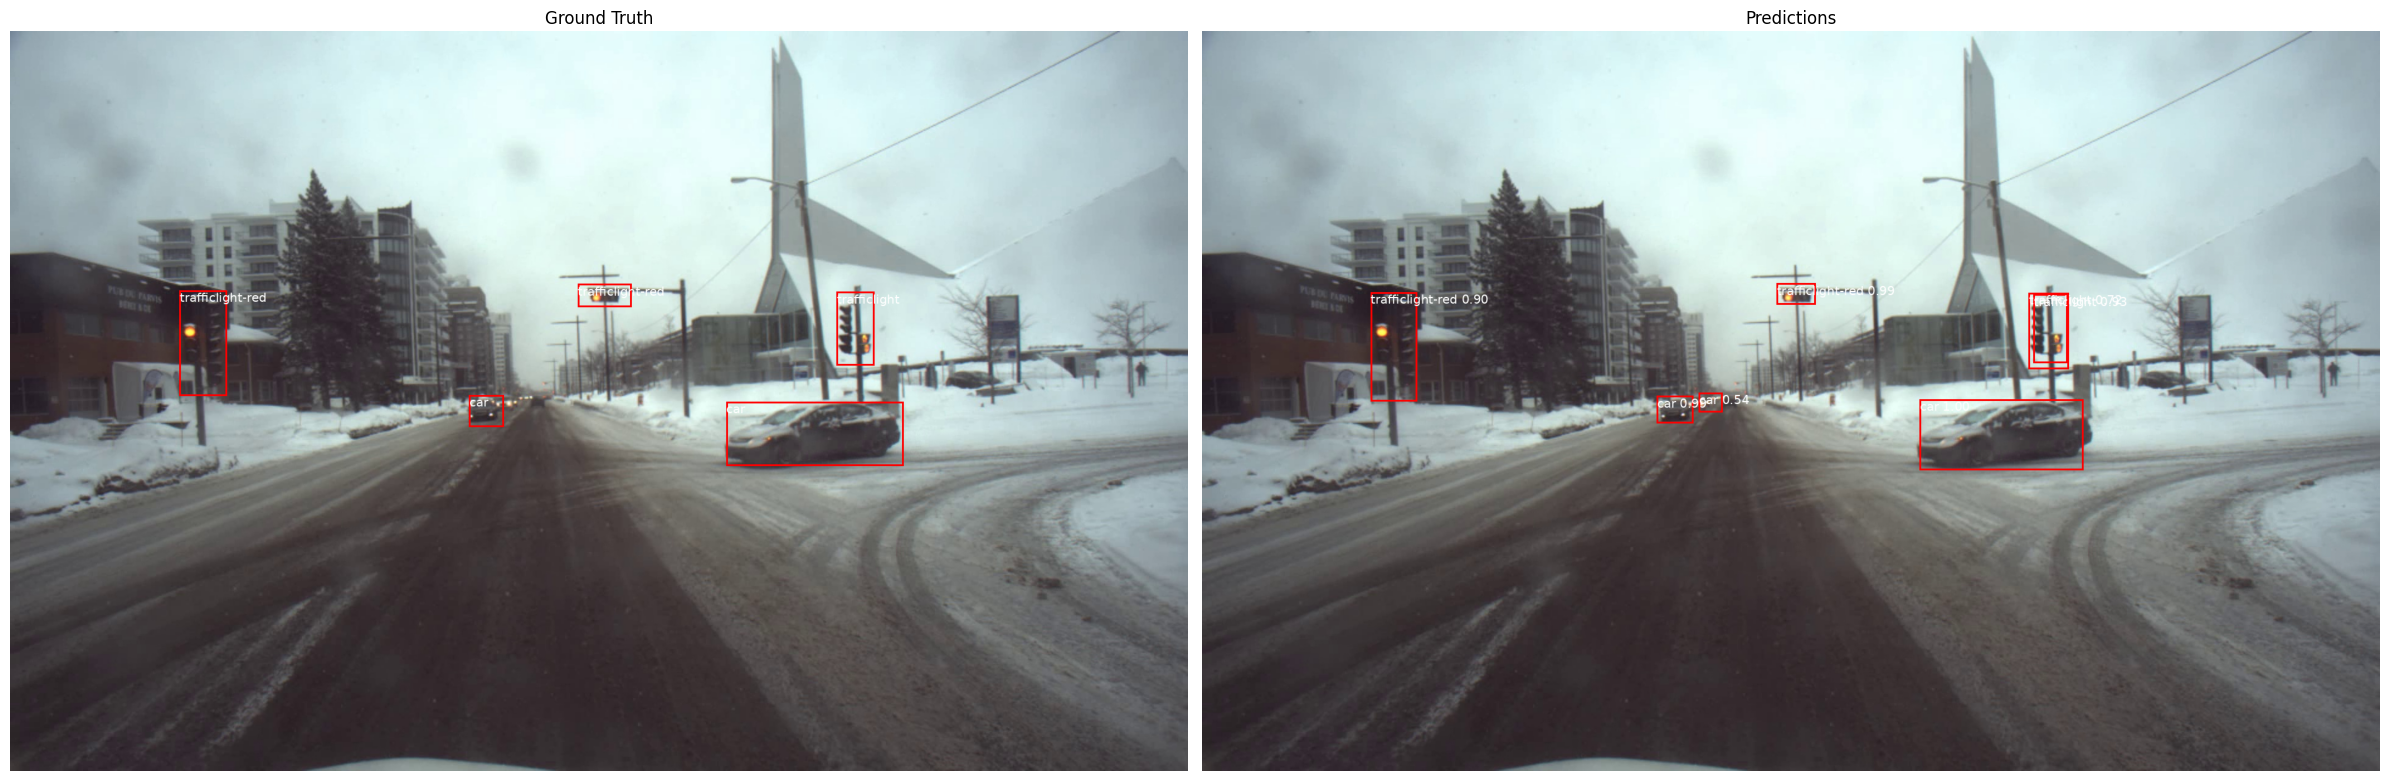

In [71]:
draw_side_by_side(7114)

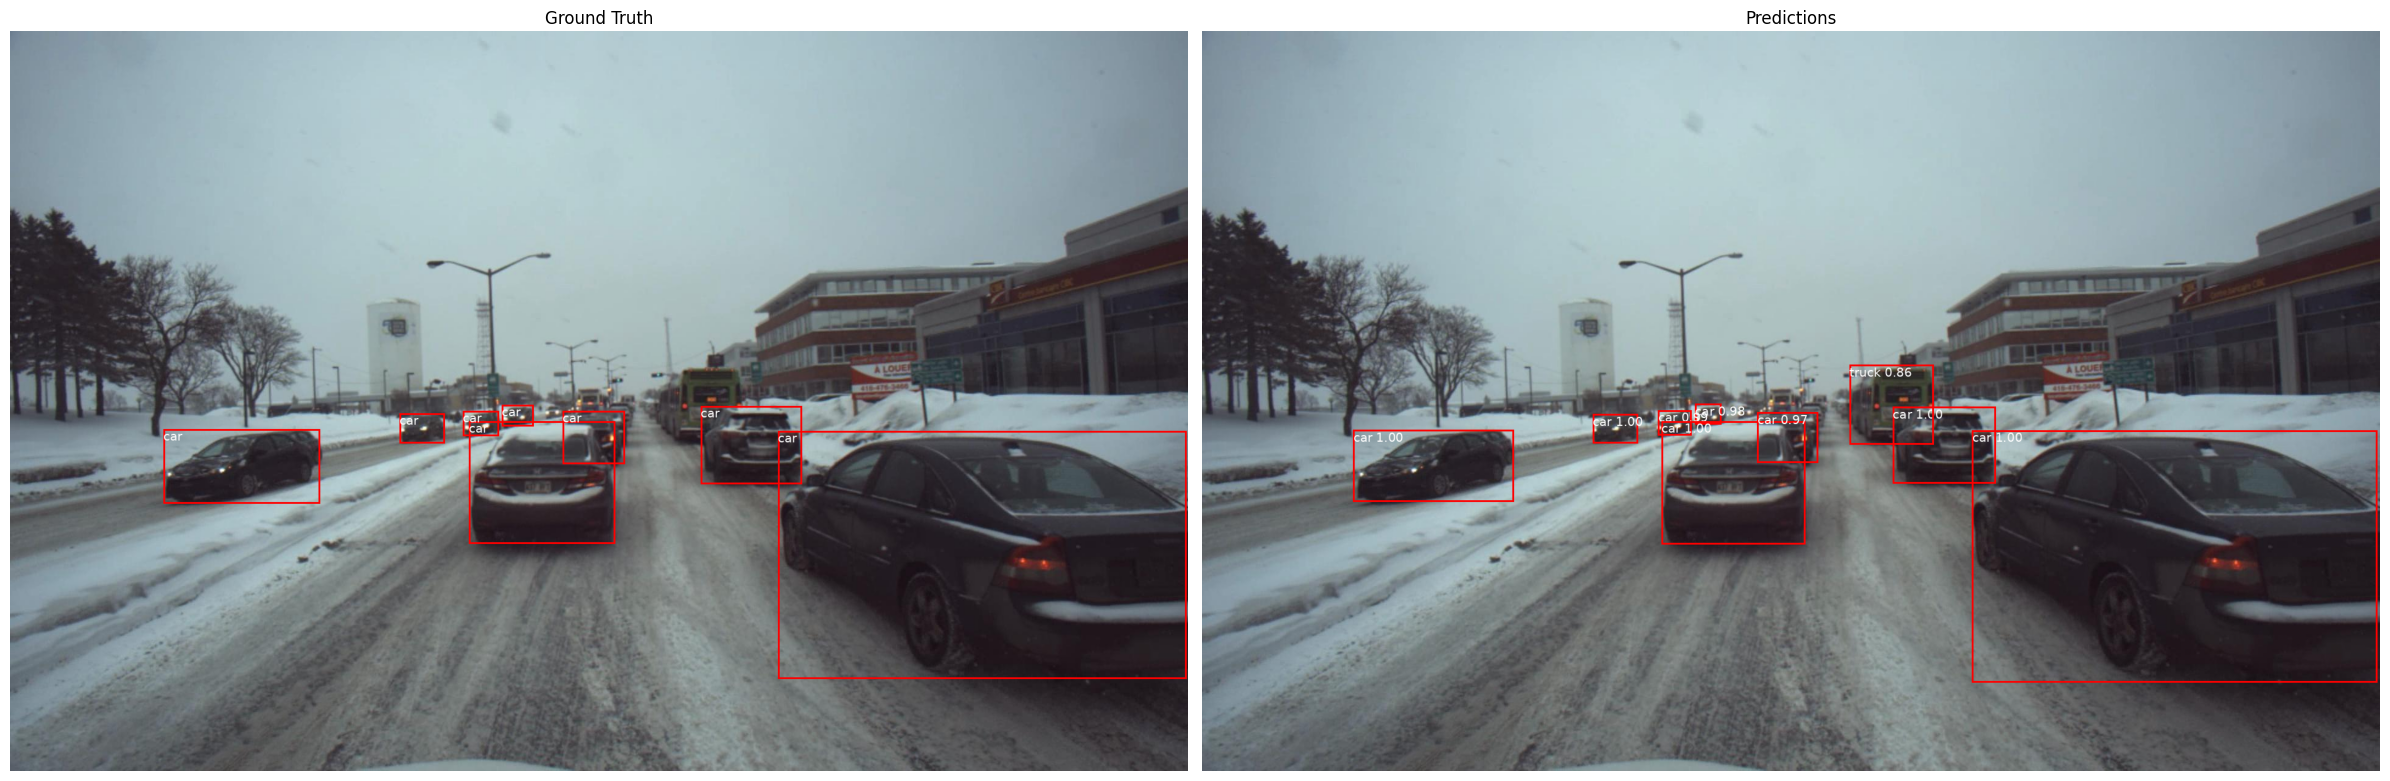

In [72]:
draw_side_by_side(1145)

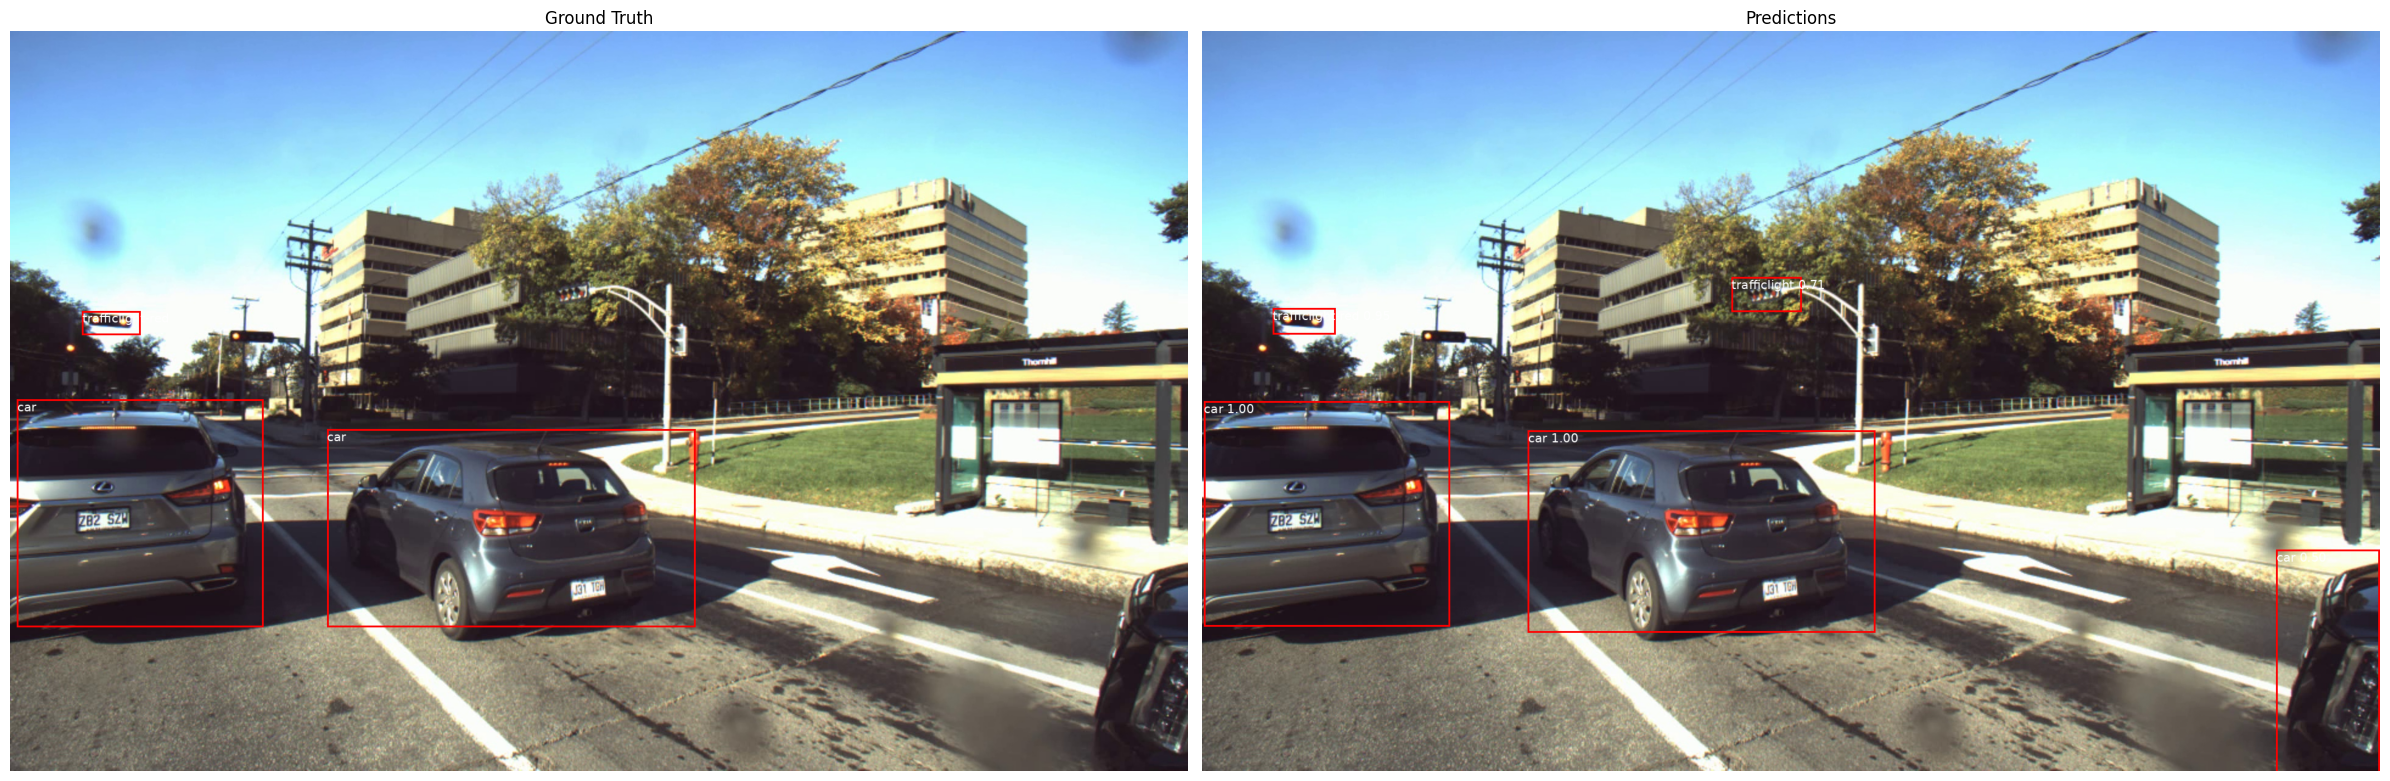

In [75]:
draw_side_by_side(7524)

In [24]:
def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    annotations = [sample['annotations'] for sample in batch]
    return images, annotations

test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

In [29]:
DEVICE = 'cuda'

tp_counter = defaultdict(int)
fp_counter = defaultdict(int)
fn_counter = defaultdict(int)

metric = MeanAveragePrecision(class_metrics=True).to(DEVICE)

In [31]:
true_labels = []
pred_labels1 = []

In [32]:

model.eval()
# Inference loop
with torch.no_grad():
    for images, annotations in test_dataloader:
        inputs = processor(images=images, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        # Run inference
        outputs = model(**inputs)
        
        target_sizes = torch.tensor([image.size[::-1] for image in images], device=DEVICE)
        
        # Post-process predictions
        results = processor.post_process_object_detection(
            outputs,
            target_sizes=target_sizes,
            threshold=0.5 
        )
        
        for i, result in enumerate(results):
            pred_boxes = result['boxes']
            pred_scores = result['scores']
            pred_labels = result['labels']
            

            sorted_indices = torch.argsort(pred_scores, descending=True)
            pred_boxes = pred_boxes[sorted_indices]
            pred_labels = pred_labels[sorted_indices]
            pred_scores = pred_scores[sorted_indices]
            
            # Ground truth
            target_boxes = torch.tensor(
                [ann['bbox'] for ann in annotations[i]['annotations']],
                dtype=torch.float32,
                device=DEVICE
            )
            if len(target_boxes) > 0:
                target_boxes[:, 2] = target_boxes[:, 0] + target_boxes[:, 2]  
                target_boxes[:, 3] = target_boxes[:, 1] + target_boxes[:, 3]
            
            target_labels = torch.tensor(
                [ann['category_id'] for ann in annotations[i]['annotations']],
                dtype=torch.int64,
                device=DEVICE
            )
            if len(target_boxes) > 0 and len(pred_boxes) > 0:
                ious = ops.box_iou(target_boxes, pred_boxes)
                max_ious, max_indices = ious.max(dim=1)
                for gt_idx, (max_iou, pred_idx) in enumerate(zip(max_ious, max_indices)):
                    if max_iou > 0.5:
                        true_labels.append(target_labels[gt_idx].item())
                        pred_labels1.append(pred_labels[pred_idx].item())
                
            # Matching predictions to ground truth
            matched_gt = set()
            for pred_box, pred_label in zip(pred_boxes, pred_labels):
                pred_label = pred_label.item()
                gt_indices = [j for j, label in enumerate(target_labels) if label.item() == pred_label and j not in matched_gt]
                if len(gt_indices) == 0:
                    fp_counter[pred_label] += 1
                    continue
                gt_boxes_same_class = target_boxes[gt_indices]
                ious = ops.box_iou(pred_box.unsqueeze(0), gt_boxes_same_class).squeeze(0)
                if len(ious) == 0:
                    fp_counter[pred_label] += 1
                    continue
                max_iou, max_idx = ious.max(0)
                gt_idx = gt_indices[max_idx]
                if max_iou > 0.5:
                    tp_counter[pred_label] += 1
                    matched_gt.add(gt_idx)
                else:
                    fp_counter[pred_label] += 1
            
            for gt_idx, gt_label in enumerate(target_labels):
                if gt_idx not in matched_gt:
                    fn_counter[gt_label.item()] += 1
        
        preds_list = [{'boxes': r['boxes'], 'scores': r['scores'], 'labels': r['labels']} for r in results]
        targets_list = [
            {
                'boxes': torch.tensor([ann['bbox'] for ann in anns['annotations']], dtype=torch.float32, device=DEVICE),
                'labels': torch.tensor([ann['category_id'] for ann in anns['annotations']], dtype=torch.int64, device=DEVICE)
            } for anns in annotations
        ]
        for t in targets_list:
            if len(t['boxes']) > 0:
                t['boxes'][:, 2] = t['boxes'][:, 0] + t['boxes'][:, 2]
                t['boxes'][:, 3] = t['boxes'][:, 1] + t['boxes'][:, 3]
        metric.update(preds_list, targets_list)

In [33]:
metrics = metric.compute()

In [39]:
metrics

{'map': tensor(0.2149),
 'map_50': tensor(0.4233),
 'map_75': tensor(0.1890),
 'map_small': tensor(0.0635),
 'map_medium': tensor(0.2595),
 'map_large': tensor(0.4052),
 'mar_1': tensor(0.1658),
 'mar_10': tensor(0.3085),
 'mar_100': tensor(0.3111),
 'mar_small': tensor(0.1327),
 'mar_medium': tensor(0.3732),
 'mar_large': tensor(0.4962),
 'map_per_class': tensor([0.3105, 0.3587, 0.2142, 0.2792, 0.0776, 0.0426, 0.2655, 0.1403, 0.1605,
         0.1448, 0.3930, 0.1914]),
 'mar_100_per_class': tensor([0.3931, 0.4665, 0.3165, 0.3923, 0.1796, 0.0908, 0.3725, 0.2272, 0.2683,
         0.2275, 0.4857, 0.3134]),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.int32)}

In [34]:

print(f"Evaluation Metrics from MeanAveragePrecision: {metrics}")

# Compute precision, recall, F1 per class
for class_id in CLASSES_ID_TO_LABELS.keys():
    tp = tp_counter[class_id]
    fp = fp_counter[class_id]
    fn = fn_counter[class_id]
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    print(f"Class {class_id} ({CLASSES_ID_TO_LABELS[class_id]}): Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


total_tp = sum(tp_counter.values())
total_fp = sum(fp_counter.values())
total_fn = sum(fn_counter.values())
micro_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
micro_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if micro_precision + micro_recall > 0 else 0
print(f"Micro-averaged Precision: {micro_precision:.4f}")
print(f"Micro-averaged Recall: {micro_recall:.4f}")
print(f"Micro-averaged F1: {micro_f1:.4f}")

Evaluation Metrics from MeanAveragePrecision: {'map': tensor(0.2149), 'map_50': tensor(0.4233), 'map_75': tensor(0.1890), 'map_small': tensor(0.0635), 'map_medium': tensor(0.2595), 'map_large': tensor(0.4052), 'mar_1': tensor(0.1658), 'mar_10': tensor(0.3085), 'mar_100': tensor(0.3111), 'mar_small': tensor(0.1327), 'mar_medium': tensor(0.3732), 'mar_large': tensor(0.4962), 'map_per_class': tensor([0.3105, 0.3587, 0.2142, 0.2792, 0.0776, 0.0426, 0.2655, 0.1403, 0.1605,
        0.1448, 0.3930, 0.1914]), 'mar_100_per_class': tensor([0.3931, 0.4665, 0.3165, 0.3923, 0.1796, 0.0908, 0.3725, 0.2272, 0.2683,
        0.2275, 0.4857, 0.3134]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.int32)}
Class 0 (N/A): Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1 (biker): Precision=0.4188, Recall=0.6490, F1=0.5091
Class 2 (car): Precision=0.4695, Recall=0.7459, F1=0.5763
Class 3 (pedestrian): Precision=0.3379, Recall=0.6301, F1=0.4399
Class 4 (trafficlight): Preci

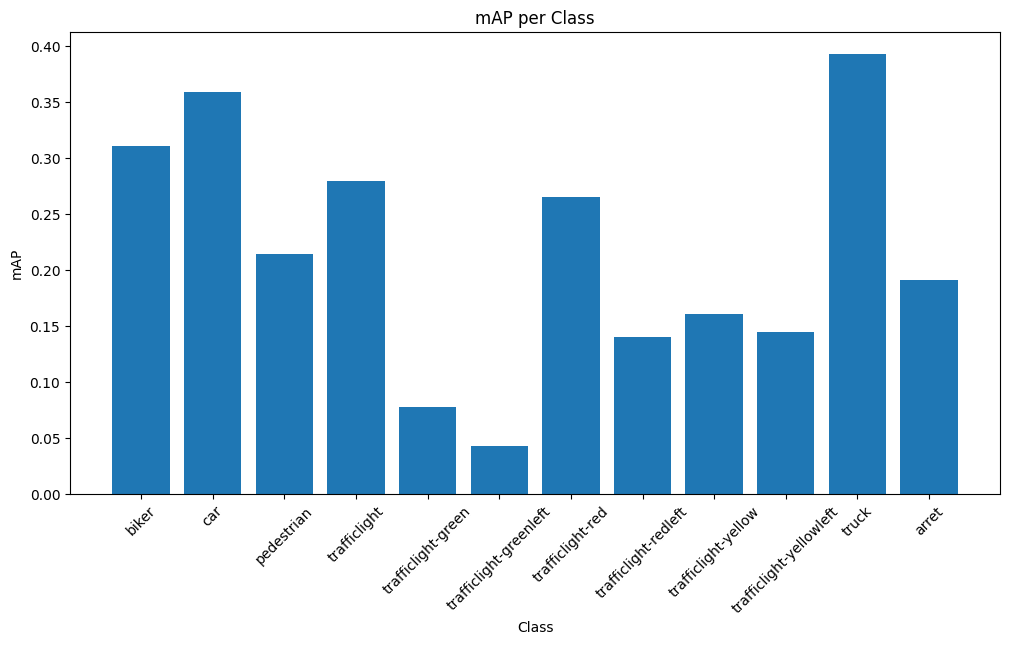

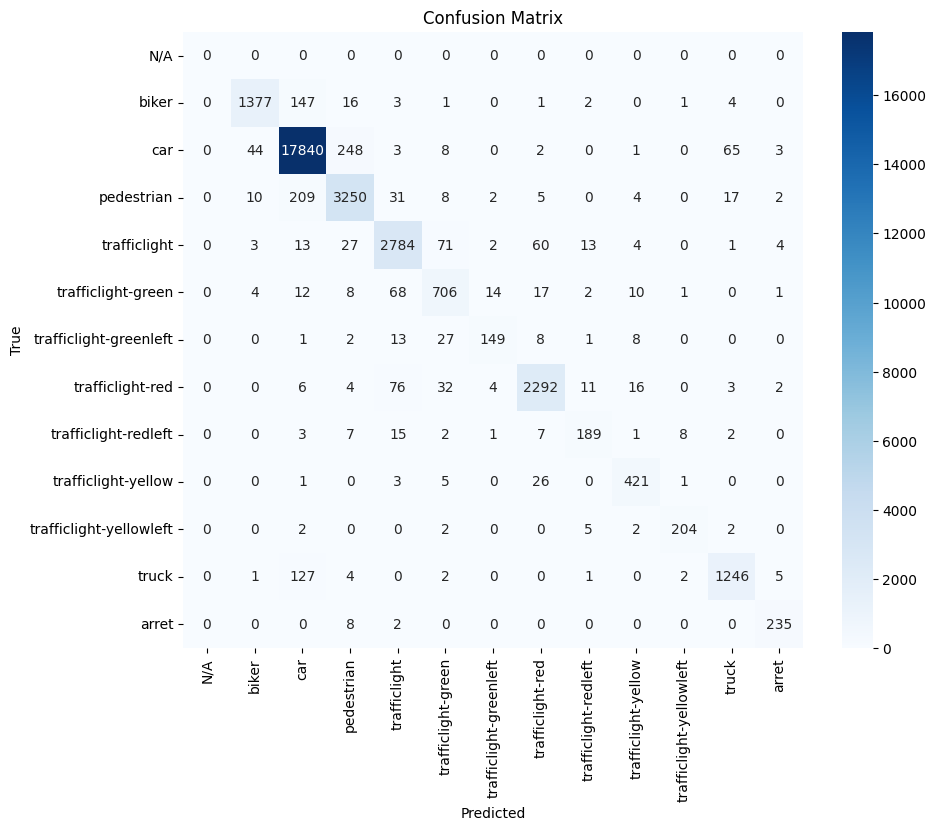

In [35]:
# metrics = metric.compute()

# Plot mAP per class
map_per_class = metrics['map_per_class'].cpu().numpy()
classes = list(model.config.id2label.values())[1:]

plt.figure(figsize=(12, 6))
plt.bar(classes, map_per_class)
plt.xlabel('Class')
plt.ylabel('mAP')
plt.title('mAP per Class')
plt.xticks(rotation=45)
plt.show()

num_classes = len(CLASSES_ID_TO_LABELS)
cm = confusion_matrix(true_labels, pred_labels1, labels=list(range(num_classes)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[CLASSES_ID_TO_LABELS[i] for i in range(num_classes)],
            yticklabels=[CLASSES_ID_TO_LABELS[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

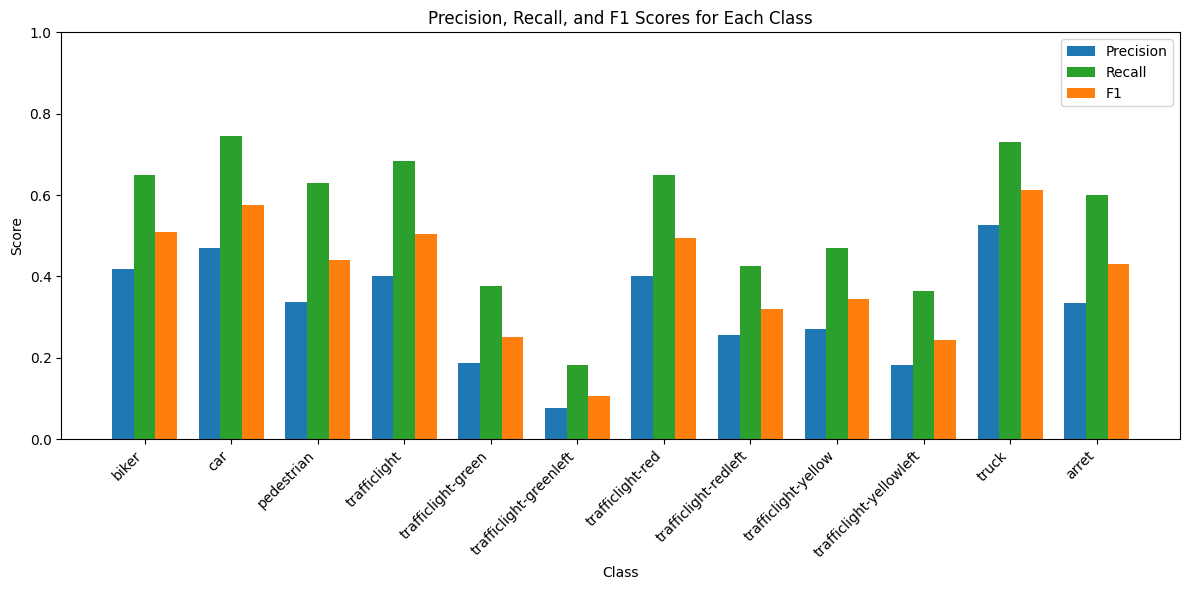

In [36]:
precision_list = []
recall_list = []
f1_list = []

for class_id in CLASSES_ID_TO_LABELS.keys():
    tp = tp_counter[class_id]
    fp = fp_counter[class_id]
    fn = fn_counter[class_id]
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

precision_list = precision_list[1:]
recall_list = recall_list[1:]
f1_list = f1_list[1:]

classes = list(CLASSES_ID_TO_LABELS.values())[1:]
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, precision_list, width, label='Precision', color='#1f77b4')
ax.bar(x, recall_list, width, label='Recall', color='#2ca02c')
ax.bar(x + width, f1_list, width, label='F1', color='#ff7f0e')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 Scores for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

In [37]:
iou_values = []
with torch.no_grad():
    for images, annotations in test_dataloader:
        inputs = processor(images=images, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        # Run inference
        outputs = model(**inputs)
        
        target_sizes = torch.tensor([image.size[::-1] for image in images], device=DEVICE)
        
        # Post-process predictions 
        results = processor.post_process_object_detection(
            outputs,
            target_sizes=target_sizes,
            threshold=0.5
        )
        
        for i, result in enumerate(results):
            pred_boxes = result['boxes']
            pred_scores = result['scores']
            pred_labels = result['labels']
            
            sorted_indices = torch.argsort(pred_scores, descending=True)
            pred_boxes = pred_boxes[sorted_indices]
            pred_labels = pred_labels[sorted_indices]
            pred_scores = pred_scores[sorted_indices]
            
            # Ground truth
            target_boxes = torch.tensor(
                [ann['bbox'] for ann in annotations[i]['annotations']],
                dtype=torch.float32,
                device=DEVICE
            )
            if len(target_boxes) > 0:
                target_boxes[:, 2] = target_boxes[:, 0] + target_boxes[:, 2] 
                target_boxes[:, 3] = target_boxes[:, 1] + target_boxes[:, 3]
            
            target_labels = torch.tensor(
                [ann['category_id'] for ann in annotations[i]['annotations']],
                dtype=torch.int64,
                device=DEVICE
            )
            if len(target_boxes > 0):
                ious = ops.box_iou(pred_boxes, target_boxes)  
                
                matched = set()  
                for pred_idx in range(len(pred_boxes)):
                    if ious[pred_idx].numel() > 0:  
                        max_iou, gt_idx = ious[pred_idx].max(), ious[pred_idx].argmax()
                        max_iou = max_iou.item()  
                        gt_idx = gt_idx.item()    
                        threshold = 0
                        if max_iou > threshold and gt_idx not in matched:
                            iou_values.append(max_iou)
                            matched.add(gt_idx)

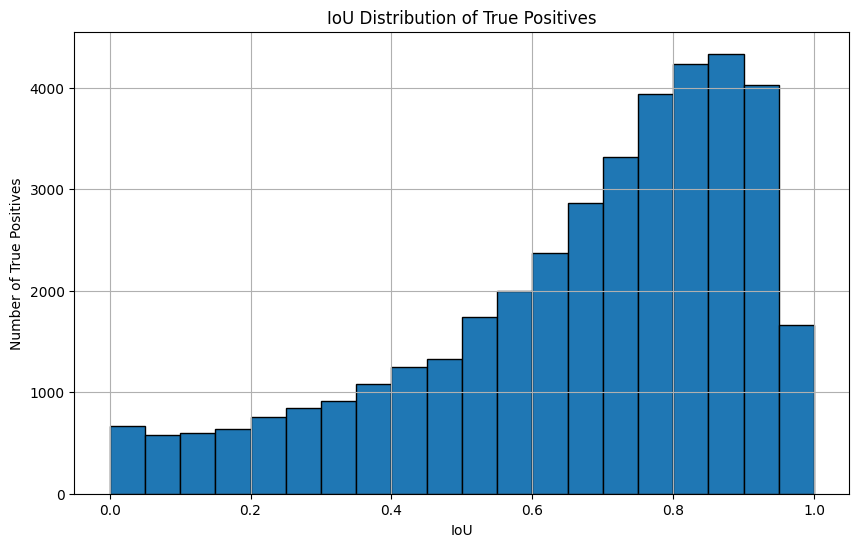

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(iou_values, bins=np.arange(0, 1.05, 0.05), edgecolor='black')
plt.xlabel('IoU')
plt.ylabel('Number of True Positives')
plt.title('IoU Distribution of True Positives')
plt.grid(True)
plt.show() 